In [ ]:
import torch
import numpy as np
from tqdm import tqdm

$X = U\Sigma V^T$, $X$ is rank $r$, here $U$ is $d \times r$, $\Sigma$ is $r \times r$ and $V^T$ is $r \times n$

In [ ]:
def create_X(d,n,r):
  X = torch.randn(d,n)
  U,S,Vh = torch.linalg.svd(X, full_matrices=False)
  S = torch.diag(S[:r])
  U = U[:,:r]
  Vh = Vh[:r,:]

  X_low = U @ S @ Vh

  return U, S, Vh, X_low

# Lemma 5

Testing for $\Sigma^{-1} K^TK \Sigma^{-1}$, were $K = - \hat{A}^+ U\Sigma$

Where $\hat{A}$ is $d \times n + d$, $\hat{A} = [A\ \ \mu I]$

In [ ]:
T = 10

mu = 0.5
r = 5
d = 1000
n = 500
c = d/n

U,S,Vh,X = create_X(d,n,r)

term = 0
for _ in tqdm(range(T)):
  A = torch.randn_like(X)/np.sqrt(d)
  hat_A = torch.cat((A, torch.eye(d)*mu), dim = 1)
  K = -1 * torch.pinverse(hat_A) @ U @ S
  term += torch.inverse(S) @ K.T @ K @ torch.inverse(S)

term/T

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


tensor([[ 2.2773e-01, -4.9450e-06, -1.8100e-04,  2.2420e-04,  2.0103e-04],
        [-4.9455e-06,  2.2684e-01,  1.4696e-04,  4.7002e-04, -3.1358e-04],
        [-1.8100e-04,  1.4696e-04,  2.2679e-01, -1.1088e-04,  8.2992e-04],
        [ 2.2420e-04,  4.7002e-04, -1.1088e-04,  2.2656e-01, -2.6598e-04],
        [ 2.0103e-04, -3.1358e-04,  8.2992e-04, -2.6598e-04,  2.2665e-01]])

In [ ]:
def k_term(c, mu, r):
  if c < 1:
    sqrt_term = np.sqrt((1 + mu**2 * c - c)**2 + 4 * mu**2 * c**2)
  else:
    sqrt_term = np.sqrt((-1 + mu**2 * c + c)**2 + 4 * mu**2 * c)
  sigma_k_term = (sqrt_term - 1 - mu**2*c + c)/(2*mu**2*c)
  return sigma_k_term

In [ ]:
k_term(c,mu,r)

0.22688411329591562

# Lemma 6

Testing for $\Sigma^{-1} K^T\hat{A}^{\dagger}(\hat{A}^{\dagger})^TK \Sigma^{-1}$, where $K = - \hat{A}^+ U\Sigma$

Where $\hat{A}$ is $d \times n + d$, $\hat{A} = [A\ \ \mu I]$

In [ ]:
T = 10

mu = 0.3
r = 5
d = 1000
n = 500
c = d/n

U,S,Vh,X = create_X(d,n,r)

term = 0
for _ in tqdm(range(T)):
  A = torch.randn_like(X)/np.sqrt(d)
  hat_A = torch.cat((A, torch.eye(d)*mu), dim = 1)
  K = -1 * torch.pinverse(hat_A) @ U @ S
  term += torch.inverse(S) @ K.T @ torch.pinverse(hat_A) @ torch.pinverse(hat_A.T) @ K @ torch.inverse(S)

term/T

100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


tensor([[62.4025, -0.3115, -0.9661, -0.3781, -0.4134],
        [-0.3115, 64.0745,  0.3703, -0.3667,  0.7472],
        [-0.9660,  0.3703, 64.3630,  0.8808,  0.5149],
        [-0.3781, -0.3667,  0.8808, 63.9411,  0.8057],
        [-0.4133,  0.7472,  0.5149,  0.8057, 63.6649]])

In [ ]:
def ka_term(c, mu, r):
  if c < 1:
    sqrt_term = np.sqrt((1 + mu**2 * c - c)**2 + 4 * mu**2 * c**2)
  else:
    sqrt_term = np.sqrt((- 1 + mu**2 * c + c)**2 + 4 * mu**2 * c)

  numerator_term = mu**2 * c**2 + c**2 + mu**2 * c - 2*c + 1
  denominator_term = sqrt_term * 2 * mu**4 * c
  ka_term = numerator_term/denominator_term + (1 - 1/c)*(1/(2*mu**4))
  return ka_term

In [ ]:
ka_term(c, mu, r)

63.56720030635941

# Lemma 7

**Testing** for $QQ^T$, where $Q=V^T(I - \hat{A}^{\dagger}\hat{A})$

Where $\hat{A}$ is $d \times n + d$, $\hat{A} = [A\ \ \mu I]$




In [ ]:
T = 250

mu = 1
r = 5
d = 750
n = 500
c = d/n

U,S,Vh,X = create_X(d,n,r)

Z = 0

term = 0
for _ in tqdm(range(T)):
  A = torch.randn_like(X)/np.sqrt(d)
  hat_A = torch.cat((A, torch.eye(d)*mu), dim=1)
  hat_X = torch.cat((X, torch.zeros(d,d)), dim=1)
  hat_U, hat_S, hat_Vh = torch.linalg.svd(hat_X, full_matrices=False)
  hat_Vh = hat_Vh[:r,:]
  Q = hat_Vh @ (torch.eye(d+n) - torch.pinverse(hat_A) @ hat_A)
  term += hat_Vh @ (torch.eye(d+n) - torch.pinverse(hat_A) @ hat_A) @ hat_Vh.T #Q @ Q.T

  Z += hat_Vh @ torch.pinverse(hat_A) @ hat_U @ torch.diag(hat_S) / T
emp = term/T
emp

100%|██████████| 250/250 [05:38<00:00,  1.36s/it]


tensor([[ 5.8042e-01, -9.9288e-05,  4.4244e-04,  6.0065e-04,  8.1751e-04],
        [-9.9290e-05,  5.8186e-01, -7.1032e-04, -3.8023e-04, -9.9994e-04],
        [ 4.4244e-04, -7.1032e-04,  5.8169e-01,  1.0859e-03,  2.2341e-04],
        [ 6.0066e-04, -3.8024e-04,  1.0859e-03,  5.8097e-01, -5.9275e-04],
        [ 8.1752e-04, -9.9994e-04,  2.2341e-04, -5.9275e-04,  5.8154e-01]])

In [ ]:
Z

tensor([[ 4.4607e-02,  3.7050e-02,  2.6194e-02,  ..., -9.6676e-10,
         -1.4663e-09, -3.2561e-10],
        [-8.1831e-02, -4.2846e-02,  2.8677e-02,  ..., -3.0035e-10,
         -5.8040e-09, -5.1171e-11],
        [-5.6031e-02,  1.0650e-02,  4.0965e-02,  ..., -4.9908e-10,
         -2.7958e-09,  6.6203e-10],
        [ 8.3809e-03,  8.1724e-02, -8.9959e-03,  ..., -4.4027e-09,
          9.4886e-10,  6.0278e-10],
        [-3.0598e-02, -6.7241e-02,  8.9924e-02,  ..., -1.4012e-09,
         -2.9504e-09,  3.6315e-10]])

In [ ]:
def Q_term(c, mu, r):
  sqrt_term = np.sqrt((-1 + mu**2 * c + c)**2 + 4 * mu**2 * c)
  theory_term = c*(1/2 + (1 + mu**2 * c - sqrt_term)/(2*c))
  Q_term = 1 - theory_term
  return Q_term

In [ ]:
(torch.diag((Q_term(c,mu,r) - emp).abs())/torch.diag(emp)).sum()/r

tensor(0.0037)

# Lemma 8

**Testing** for $\Sigma^{-1}H_1\Sigma^{-1}$ and $\Sigma H_1^{-1}\Sigma$, where $H_1= K^TK + Z^T(QQ^T)^{-1}Z$ and $Z = I + V_{trn}^T\hat{A}_{trn}^\dagger U\Sigma_{trn}$ and $Q = V^T(I - \hat{A}_{trn}^\dagger \hat{A}_{trn})$.

In [ ]:
T = 10

mu = 2
r = 5
d = 500
n = 750

U,S,Vh,X = create_X(d,n,r)

A = torch.randn_like(X)/np.sqrt(d)
hat_A = torch.cat((A, torch.eye(d)*mu), dim = 1)
hat_X = torch.cat((X, torch.zeros(d,d)), dim=1)
hat_U, hat_S, hat_Vh = torch.linalg.svd(hat_X, full_matrices=False)
hat_S[:r].mean()

tensor(48.5075)

In [ ]:
# d < N

T = 10

mu = 0.2
r = 5
d = 1000
n = 500

U,S,Vh,X = create_X(d,n,r)

term = 0
sigma = 0
for _ in tqdm(range(T)):
  A = torch.randn_like(X)/np.sqrt(d)
  hat_A = torch.cat((A, torch.eye(d)*mu), dim = 1)
  hat_X = torch.cat((X, torch.zeros(d,d)), dim=1)
  hat_U, hat_S, hat_Vh = torch.linalg.svd(hat_X, full_matrices=False)
  hat_Vh = hat_Vh[:r,:]
  sigma_mean = hat_S[:r].mean()
  Q = hat_Vh @ (torch.eye(d+n) - torch.pinverse(hat_A) @ hat_A)
  K = -1 * torch.pinverse(hat_A) @ U @ S
  Z = torch.eye(r) + hat_Vh @ torch.pinverse(hat_A) @ hat_U @ hat_S
  H_1 = K.T @ K + Z.T @ torch.inverse(Q @ Q.T) @ Z
  term += S @ torch.inverse(H_1) @ S
  sigma += sigma_mean

sigma = sigma/T
emp = term/T
emp

100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


tensor([[ 7.2480e-02, -2.7219e-04,  1.1998e-03,  5.3179e-04,  9.5131e-04],
        [-2.7219e-04,  7.3850e-02,  6.2478e-04, -8.7923e-04, -4.3968e-05],
        [ 1.1998e-03,  6.2478e-04,  7.3021e-02,  7.5669e-06,  7.1897e-04],
        [ 5.3179e-04, -8.7923e-04,  7.5668e-06,  7.1634e-02,  2.6873e-03],
        [ 9.5131e-04, -4.3968e-05,  7.1897e-04,  2.6873e-03,  7.2727e-02]])

In [ ]:
def h1_term1(c, mu, r, sigma):
  sqrt_term = np.sqrt((1 + mu**2 * c - c)**2 + 4 * mu**2 * c**2)
  numerator = 2 * mu**2 * c * sigma**2
  denominator = (sqrt_term - 1 - mu**2 * c + c) * sigma**2 + 2 * mu**2 * c * (c+1)
  h1_term1 = numerator / denominator
  return h1_term1

def h1_term(c, mu, r, Sigma):
  if c < 1:
    sqrt_term = np.sqrt((1 + mu**2 * c - c)**2 + 4 * mu**2 * c**2)
  else:
    sqrt_term = np.sqrt((-1 + mu**2 * c + c)**2 + 4 * mu**2 * c)
  term = (sqrt_term  - 1 - mu**2 *c + c)/(2*mu**2*c)

  Qterm = torch.linalg.inv(Sigma @ Sigma)/Q_term(c,mu,r)

  return torch.linalg.inv(term * torch.eye(r) + Qterm)

In [ ]:
c = d/n
Sigma = S
torch.diag((h1_term(c,mu,r,Sigma) - emp).abs()/emp).mean()

tensor(0.0279)

In [ ]:
# d > N

T = 10

mu = 0.5
r = 5
d = 750
n = 500

U,S,Vh,X = create_X(d,n,r)

term = 0
sigma = 0
for _ in tqdm(range(T)):
  A = torch.randn_like(X)/np.sqrt(d)
  hat_A = torch.cat((A, torch.eye(d)*mu), dim = 1)
  hat_X = torch.cat((X, torch.zeros(d,d)), dim=1)
  hat_U, hat_S, hat_Vh = torch.linalg.svd(hat_X, full_matrices=False)
  hat_Vh = hat_Vh[:r,:]
  sigma_mean = hat_S[:r].mean()
  Q = hat_Vh @ (torch.eye(d+n) - torch.pinverse(hat_A) @ hat_A)
  K = -1 * torch.pinverse(hat_A) @ U @ S
  Z = torch.eye(r) + hat_Vh @ torch.pinverse(hat_A) @ hat_U @ hat_S
  H_1 = K.T @ K + Z.T @ torch.inverse(Q @ Q.T) @ Z
  term += S @ torch.inverse(H_1) @ S
  sigma += sigma_mean

sigma = sigma/T
term/T

 20%|██        | 2/10 [00:03<00:12,  1.60s/it]


KeyboardInterrupt: 

In [ ]:
def h1_term2(c, mu, r, sigma):
  sqrt_term = np.sqrt((-1 + mu**2 * c + c)**2 + 4 * mu**2 * c)
  numerator = 2 * mu**2 * c * sigma**2
  denominator = (sqrt_term - 1 - mu**2 * c + c) * sigma**2 + 2 * mu**2 * c * (c+1)
  h1_term2 = numerator / denominator
  return h1_term2

# Lemma 9

Testing for $HH^T$, where $H = V_{trn}^T\hat{A}_{trn}^\dagger$.

In [ ]:
# d < N

T = 10

mu = 0.5
r = 5
d = 500
n = 750

U,S,Vh,X = create_X(d,n,r)

term = 0
sigma = 0
for _ in tqdm(range(T)):
  A = torch.randn_like(X)/np.sqrt(d)
  hat_A = torch.cat((A, torch.eye(d)*mu), dim = 1)
  hat_X = torch.cat((X, torch.zeros(d,d)), dim=1)
  hat_U, hat_S, hat_Vh = torch.linalg.svd(hat_X, full_matrices=False)
  hat_Vh = hat_Vh[:r,:]
  H = hat_Vh @ torch.pinverse(hat_A)
  term += H @ H.T

term/T

100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


tensor([[ 0.3865,  0.0047,  0.0009,  0.0010,  0.0034],
        [ 0.0047,  0.3991, -0.0005, -0.0032,  0.0068],
        [ 0.0009, -0.0005,  0.3969,  0.0022, -0.0007],
        [ 0.0010, -0.0032,  0.0022,  0.3952, -0.0015],
        [ 0.0034,  0.0068, -0.0007, -0.0015,  0.3896]])

In [ ]:
def h_term(c, mu, r):
  if c < 1:
    sqrt_term = np.sqrt((1 + mu**2 * c - c)**2 + 4 * mu**2 * c**2)
    h_term1 = c * ((1 + c + mu**2 * c) / (2 * sqrt_term) - 1/2)
    return h_term1
  else:
    sqrt_term = np.sqrt((-1 + mu**2 * c + c)**2 + 4 * mu**2 * c)
    h_term2 = c * ((1 + c + mu**2 * c) / (2 * sqrt_term) - 1/2)
    return h_term2

In [ ]:
# d > N

T = 10

mu = 0.5
r = 5
d = 750
n = 500

U,S,Vh,X = create_X(d,n,r)

term = 0
sigma = 0
for _ in tqdm(range(T)):
  A = torch.randn_like(X)/np.sqrt(d)
  hat_A = torch.cat((A, torch.eye(d)*mu), dim = 1)
  hat_X = torch.cat((X, torch.zeros(d,d)), dim=1)
  hat_U, hat_S, hat_Vh = torch.linalg.svd(hat_X, full_matrices=False)
  hat_Vh = hat_Vh[:r,:]
  H = hat_Vh @ torch.pinverse(hat_A)
  term += H @ H.T

term/T

100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


tensor([[ 6.8291e-01, -1.3126e-04, -7.0436e-04,  8.7437e-04, -3.1677e-03],
        [-1.3126e-04,  6.8087e-01,  2.5656e-03,  2.9179e-03, -4.7257e-03],
        [-7.0436e-04,  2.5656e-03,  6.7740e-01, -2.7537e-03,  5.5194e-03],
        [ 8.7437e-04,  2.9179e-03, -2.7537e-03,  6.8073e-01, -5.8233e-03],
        [-3.1677e-03, -4.7257e-03,  5.5194e-03, -5.8233e-03,  6.8886e-01]])

In [ ]:
def h_term2(c, mu, r):
  sqrt_term = np.sqrt((-1 + mu**2 * c + c)**2 + 4 * mu**2 * c)
  h_term2 = c * ((1 + c + mu**2 * c) / (2 * sqrt_term) - 1/2)
  return h_term2

# W Term

Testing for $\|W\|^2$, where $W = -U\Sigma_{trn} H_1^{-1} K^TA_{trn}^\dagger + U \Sigma_{trn} H_1^{-1}Z^T(QQ^T)^{-1}H$.

In [ ]:
# d < N

T = 10

mu = 2
r = 5
d = 500
n = 750

U,S,Vh,X = create_X(d,n,r)

term = 0
sigma = 0
for _ in tqdm(range(T)):
  A = torch.randn_like(X)/np.sqrt(d)
  hat_A = torch.cat((A, torch.eye(d)*mu), dim = 1)
  hat_X = torch.cat((X, torch.zeros(d,d)), dim=1)
  hat_U, hat_S, hat_Vh = torch.linalg.svd(hat_X, full_matrices=False)
  sigma_mean = hat_S[:r].mean()
  hat_S = torch.diag(hat_S[:r])
  hat_U = hat_U[:,:r]
  hat_Vh = hat_Vh[:r,:]
  H = hat_Vh @ torch.pinverse(hat_A)
  Q = hat_Vh @ (torch.eye(d+n) - torch.pinverse(hat_A) @ hat_A)
  K = -1 * torch.pinverse(hat_A) @ U @ S
  Z = torch.eye(r) + hat_Vh @ torch.pinverse(hat_A) @ hat_U @ hat_S
  H_1 = K.T @ K + Z.T @ torch.inverse(Q @ Q.T) @ Z
  W = - hat_U @ hat_S @ torch.inverse(H_1) @ K.T @ torch.pinverse(hat_A) + hat_U @ hat_S @ torch.inverse(H_1) @ Z.T @ torch.inverse(Q @ Q.T) @ H
  term += torch.linalg.norm(W)**2

sigma = sigma/T
term/T

100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


tensor(5.1572)

In [ ]:
# def w_term1(c, mu, r, sigma):
#   first_part = r *(ka_term1(c, mu, r) * h1_term1(c, mu, r, sigma)**2)
#   second_part = r * Q_term(c, mu, r)**(-2) * h_term1(c, mu, r) * h1_term1(c, mu, r, sigma)**2 * sigma**(-2)
#   term = first_part + second_part
#   return term


def w_term(c,mu,r,sigma):
  term1 = ka_term(c, mu, r) * h1_term(c, mu, r, sigma)**2
  term2 = h_term(c,mu,r) * Q_term(c, mu, r)**(-2) * h1_term(c, mu, r, sigma)**2 * sigma**(-2)
  return torch.trace(term1) + torch.trace(term2)

In [ ]:
c = d/n
sigma = S
w_term(c,mu,r,sigma)

tensor(5.1736)

In [ ]:
d = 500
n = 750
c = d/n
r = 5
mu = 0.5
w_term1(c, mu, r, sigma)

tensor(7.9921)

In [ ]:
# d > N

T = 10

mu = 0.5
r = 5
d = 750
n = 500

U,S,Vh,X = create_X(d,n,r)

term = 0
sigma = 0
for _ in tqdm(range(T)):
  A = torch.randn_like(X)/np.sqrt(d)
  hat_A = torch.cat((A, torch.eye(d)*mu), dim = 1)
  hat_X = torch.cat((X, torch.zeros(d,d)), dim=1)
  hat_U, hat_S, hat_Vh = torch.linalg.svd(hat_X, full_matrices=False)
  sigma_mean = hat_S[:r].mean()
  hat_S = torch.diag(hat_S[:r])
  hat_U = hat_U[:,:r]
  hat_Vh = hat_Vh[:r,:]
  H = hat_Vh @ torch.pinverse(hat_A)
  Q = hat_Vh @ (torch.eye(d+n) - torch.pinverse(hat_A) @ hat_A)
  K = -1 * torch.pinverse(hat_A) @ U @ S
  Z = torch.eye(r) + hat_Vh @ torch.pinverse(hat_A) @ hat_U @ hat_S
  H_1 = K.T @ K + Z.T @ torch.inverse(Q @ Q.T) @ Z
  W = - hat_U @ hat_S @ torch.inverse(H_1) @ K.T @ torch.pinverse(hat_A) + hat_U @ hat_S @ torch.inverse(H_1) @ Z.T @ torch.inverse(Q @ Q.T) @ H
  term += torch.linalg.norm(W)**2
  sigma += sigma_mean

sigma = sigma/T
term/T

100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


tensor(7.2040)

In [ ]:
def w_term2(c, mu, r, sigma):
  first_part = r *(ka_term2(c, mu, r) * h1_term2(c, mu, r, sigma)**2)
  second_part = r * Q_term(c, mu, r)**(-2) * h_term2(c, mu, r) * h1_term2(c, mu, r, sigma)**2 * sigma**(-2)
  term = first_part + second_part
  return term

In [ ]:
d = 750
n = 500
c = d/n
r = 5
mu = 0.5
w_term2(c, mu, r, sigma)

tensor(7.2711)

# Regularization Error


Testing for the regularization error, where $R = \frac{1}{N_{tst}}\|U \Sigma_{trn} H_1^{-1}Z^T(QQ^T)^{-1}\Sigma_{trn}^{-1}L\|_F^2 + \frac{\eta_{tst}^2}{d} \|W\|_F^2$.

In [ ]:
T = 10

mu = 2
r = 7
d = 1000
n = 700

U,S,Vh,X = create_X(d,n,r)

term = 0
sigma = 0
for _ in tqdm(range(T)):
  A = torch.randn_like(X)/np.sqrt(d)
  hat_A = torch.cat((A, torch.eye(d)*mu), dim = 1)
  hat_X = torch.cat((X, torch.zeros(d,d)), dim=1)
  hat_U, hat_S, hat_Vh = torch.linalg.svd(hat_X, full_matrices=False)
  sigma_mean = hat_S[:r].mean()
  hat_S = torch.diag(hat_S[:r])
  hat_U = hat_U[:,:r]
  hat_Vh = hat_Vh[:r,:]
  L = hat_S @ hat_Vh
  H = hat_Vh @ torch.pinverse(hat_A)
  Q = hat_Vh @ (torch.eye(d+n) - torch.pinverse(hat_A) @ hat_A)
  K = -1 * torch.pinverse(hat_A) @ U @ S
  Z = torch.eye(r) + hat_Vh @ torch.pinverse(hat_A) @ hat_U @ hat_S
  H_1 = K.T @ K + Z.T @ torch.inverse(Q @ Q.T) @ Z
  W = - hat_U @ hat_S @ torch.inverse(H_1) @ K.T @ torch.pinverse(hat_A) + hat_U @ hat_S @ torch.inverse(H_1) @ Z.T @ torch.inverse(Q @ Q.T) @ H
  part_R = U @ hat_S @ torch.inverse(H_1) @ Z.T @ torch.inverse(Q @ Q.T) @ torch.inverse(hat_S) @ L
  term += 1/d * torch.linalg.norm(W)**2 + 1/n * torch.linalg.norm(part_R)**2

term/T

100%|██████████| 10/10 [00:41<00:00,  4.20s/it]


tensor(0.0073)

In [ ]:
def regularization_error(c, mu, r, sigma, n, d, L):
  h1 = h1_term(c, mu, r, sigma)
  Q = Q_term(c, mu, r)
  part = h1 @ torch.linalg.inv(sigma) @ torch.linalg.inv(sigma) @ L / Q
  term = 1/d * w_term(c, mu, r, sigma) + part.square().sum()/n
  return term

In [ ]:
c = d/n
sigma = S
regularization_error(c, mu, r, sigma)

tensor(0.0071)

In [ ]:
def calc_lambda_inverse_N(c,mu):
  b = -(1-c+mu**2)
  a = -c*mu**2
  cq = 1
  numerator1 = -1*b - np.sqrt(b ** 2 - 4*a*cq)
  numerator2 = -1*b + np.sqrt(b ** 2 - 4*a*cq)
  denominator = 2*a
  return numerator1/denominator

def calc_lambda_inverse_M(c,mu):
  if c < 1:
    return c*calc_lambda_inverse_N(c, np.sqrt(c)*mu)
  else:
    return calc_lambda_inverse_N(1/c,mu)

def calc_tau(c,mu,theta):
  return 1+(theta**2)*calc_tnorm(c,mu)*calc_knorm(c,mu)

def calc_bias(c,mu,theta,thetatst,Ntst):
  return (thetatst**2)/(Ntst*calc_tau(c,mu,theta)**2)

def calc_lambda_inverse_square_N(c,mu):
  m = calc_lambda_inverse_N(c,mu)
  num = c*m*m + m
  den = -2*c*mu*mu*m - 1 + c - mu**2
  return -1*num/den

def calc_lambda_inverse_square_M(c,mu):
  if c < 1:
    return c*c*calc_lambda_inverse_square_N(c, np.sqrt(c)*mu)
  else:
    return calc_lambda_inverse_square_N(1/c, mu)

def calc_scale(c,mu):
  if c < 1:
    return 1 - (mu**2)*calc_lambda_inverse_M(c,mu)
  else:
    return 1 - (mu**2)*calc_lambda_inverse_N(1/c,mu)

def calc_scale_squared(c,mu):
  if c < 1:
    return calc_lambda_inverse_M(c, mu) - (mu**2)*calc_lambda_inverse_square_M(c, mu)
  else:
    return calc_lambda_inverse_N(1/c, mu) - (mu**2)*calc_lambda_inverse_square_N(1/c, mu)

def calc_tnorm(c,mu):
  return 1 - calc_scale(c,mu)*np.minimum(1,c)

def calc_hnorm(c,mu):
  return np.minimum(1,c)*calc_scale_squared(c,mu)

def calc_scale_both_squared(c,mu):
  return calc_scale(c,mu) - (mu**2)*calc_scale_squared(c,mu)

def calc_lambda_inverse_cube_N(c,mu):
  z = -1*(mu**2)
  m = calc_lambda_inverse_N(c,mu)
  Lz = (c*m**2 + m)
  Lm = 2*c*z*m - (1 - c - z)
  Lzm = 2*c*m+1
  Lmm = 2*c*z

  numerator = 2*Lz*Lm*Lzm - (Lz**2)*Lmm
  denominator = 2*(Lm ** 3)

  return numerator/denominator

def calc_lambda_inverse_cube_M(c,mu):
  if c< 1:
    return c*c*c*calc_lambda_inverse_cube_N(c, np.sqrt(c)*mu)
  else:
    return calc_lambda_inverse_cube_N(1/c,mu)

def calc_knorm(c,mu):
  if c < 1:
    return calc_lambda_inverse_M(c,mu)
  else:
    return calc_lambda_inverse_N(1/c,mu)/c + (1-1/c)/(mu**2)

def calc_trace_term(c,mu):
  if c < 1:
    return calc_lambda_inverse_square_M(c,mu)
  else:
    return calc_lambda_inverse_square_N(1/c,mu)/c + (1-1/c)/(mu**4)

def calc_term1(c,mu,theta):
  return (theta**2)*calc_hnorm(c,mu)/(calc_tau(c,mu,theta)**2)

def calc_term2(c,mu,theta):
  return (theta**4)*(calc_tnorm(c,mu)**2)*(calc_trace_term(c,mu))/(calc_tau(c,mu,theta)**2)

def calc_wnorm(c,mu,theta):
  return calc_term1(c,mu,theta)+calc_term2(c,mu,theta)

def calc_gen_error(c,mu,theta,thetatst,Ntst,M):
  return calc_bias(c,mu,theta,thetatst,Ntst) + calc_wnorm(c,mu,theta)/M

def optimal_theta(c,mu,thetatst,Ntst,M):
  num = 2 * (thetatst**2 / Ntst) * calc_tnorm(c,mu) * calc_knorm(c,mu) * M - calc_hnorm(c,mu)
  denom = 2 * calc_tnorm(c,mu) ** 2 * calc_trace_term(c,mu) - calc_hnorm(c,mu) * calc_tnorm(c,mu) * calc_knorm(c,mu)
  return np.sqrt(num / denom)

# Reg Error vs c

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision

In [ ]:
MNIST = torchvision.datasets.MNIST("./", train = True, download = True)
MNIST_test = torchvision.datasets.MNIST("./", train = False, download = True)
X = MNIST.data.reshape(-1,784).to(torch.float)/255
Xtst_F = MNIST_test.data.reshape(-1,784).to(torch.float)/255
Xtst_F = Xtst_F.T

In [ ]:
def sim(X, A, mu):
  d = X.shape[0]
  Xhat = torch.cat((X, torch.zeros(d,d)), dim=1)
  Ahat = torch.cat((A, mu*torch.eye(d)), dim=1)
  What = Xhat @ torch.pinverse(Xhat+Ahat)
  return What

100%|██████████| 93/93 [12:19<00:00,  7.96s/it]


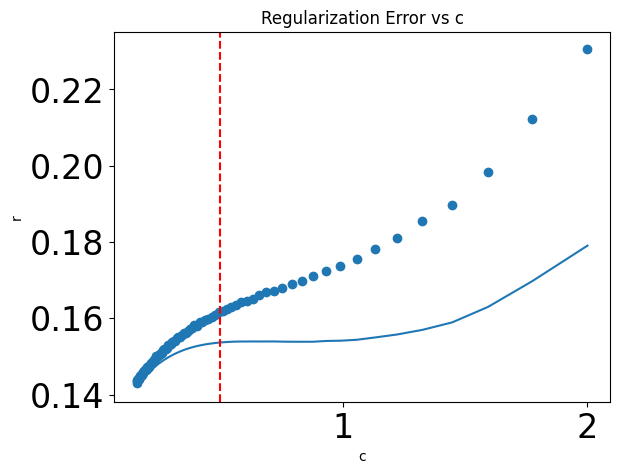

In [ ]:
reg_err = []
test_mse = []
c_list = []

#d = 1000
d = 784
N = 5000
mu = 1
r = 100
#U,S,Vh,X = create_X(d,N,r)
#L = torch.randn(r,N)
#Xtst = U @
#Xp = (X @ P).T
X = MNIST.data.reshape(-1,784).to(torch.float)/255

X = X.T[:,:N]
U,S,Vh = torch.linalg.svd(X)
U = U[:,:r]
S = S[:r]
Vh = Vh[:r,:]
X = U @ torch.diag(S) @ Vh
L = U.T @ Xtst_F[:,:N]
Xtst = U @ L
sigma = S

num_trails = 5

a = int(d/2)
for n in tqdm(range(a,5000,50)):
  _, S, Vh = torch.linalg.svd(X[:,:n])
  Vh = Vh[:r,:]
  Sigma = torch.diag(S[:r])
  c = d/n
  c_list.append(c)
  reg = regularization_error(c, mu, r, Sigma, N, d, L)
  reg_err.append(reg)

  tst_mse = 0
  norm = 0

  for nt in range(num_trails):
    Xtrn = X[:,:n]
    Atrn = torch.randn_like(X[:,:n])/np.sqrt(d)
    What = sim(Xtrn, Atrn, mu)
    Xtest = Xtst + torch.randn_like(Xtst)/np.sqrt(d)

    #bias = Xtst - What @ Xtst

    #Xhat = torch.cat((Xtrn, torch.zeros(d,d)),dim=1)
    #_,_,Vhath = torch.linalg.svd(Xhat)
    #Vhath = Vhath[:r,:]
    #Ahat = torch.cat((Atrn, mu*torch.eye(d)),dim=1)
    #Ap = torch.pinverse(Ahat)
    #H = Vhath @ Ap
    #K = -1 * Ap @ U @ Sigma
    #Z = torch.eye(r) + Vhath @ Ap @ U @ Sigma
    #Q = Vhath @ (torch.eye(d+n) - Ap @ Ahat)
    #H1 = K.T @ K + Z.T @ torch.linalg.inv(Q @ Q.T) @ Z
    #t_bias = U @ Sigma @ torch.linalg.inv(H1) @ Z.T @ torch.linalg.inv(Q @ Q.T) @ torch.linalg.inv(Sigma) @ L

    #W_theory = -1 * U @ Sigma @ torch.linalg.inv(H1) @ K.T @ Ap + U @ Sigma @ torch.linalg.inv(H1) @ Z.T  @ torch.linalg.inv(Q @ Q.T) @ H
    #t_bias_2 = Xtst - W_theory @ Xtst

    #bias_diff.append((bias-t_bias).norm()/bias.norm())

    #norm += What.square().sum()/num_trails

    tst_mse += (Xtst - What @ Xtest).square().sum()/(N)
  test_mse.append(tst_mse/num_trails)
  #emp_norm.append(norm)
  #theory_norm.append(w_term(c,mu,r,Sigma))

plt.plot(c_list, reg_err, linestyle='-')
plt.scatter(c_list, test_mse)
plt.axvline(x=1/(mu**2+1), color='red', linestyle='--')
plt.xlabel('c')
plt.ylabel('r')
plt.title('Regularization Error vs c')
plt.show()

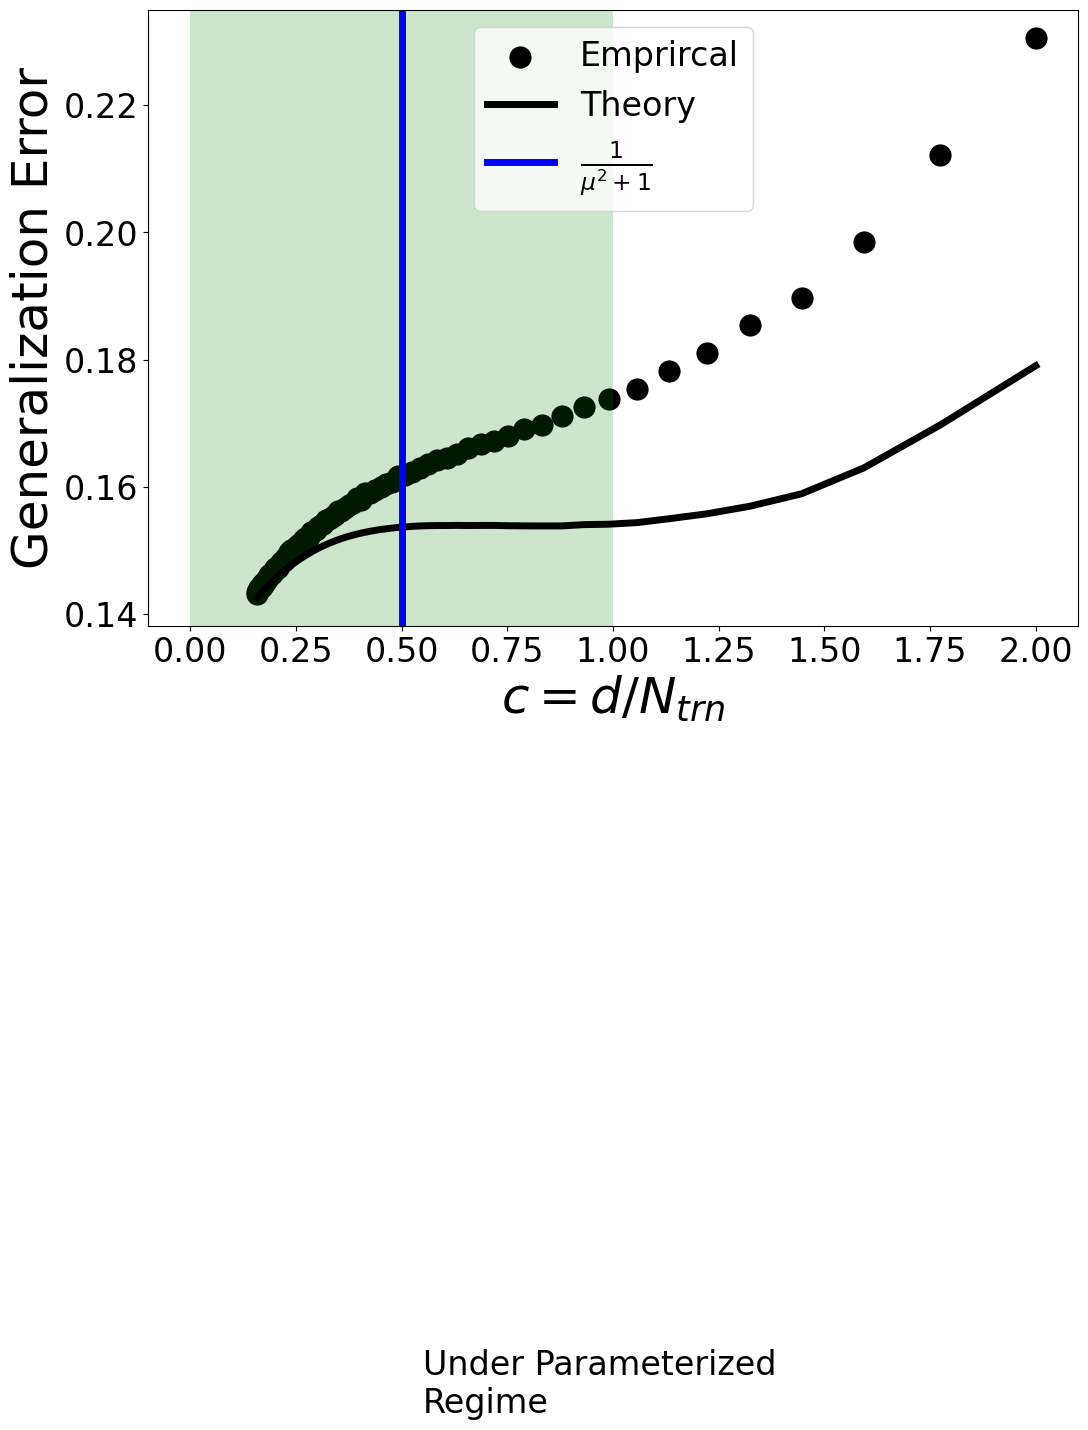

In [ ]:
fig,_ = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)

plt.scatter(c_list, test_mse, label = "Emprircal", linewidth = 10, color = "black")
plt.plot(c_list, reg_err, label = "Theory", linewidth = 5, color = "black")
plt.axvline(x=1/(mu**2+1), color="blue", linewidth = 5, label = r"$\frac{1}{\mu^2+1}$")
plt.legend(fontsize = 24)
plt.xlabel(r"$c=d/N_{trn}$", fontsize = 36)
plt.axvspan(0, 1, color="green", alpha=0.2, lw=0)
plt.text(0.55,0.0143,"Under Parameterized \nRegime", fontsize = 24)
plt.ylabel(r"Generalization Error", fontsize = 36)
plt.savefig("r-"+str(r)+"-mu-"+str(mu)+"-mnist-data.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

In [ ]:
plt.plot(c_list, theory_norm)
plt.scatter(c_list, emp_norm)

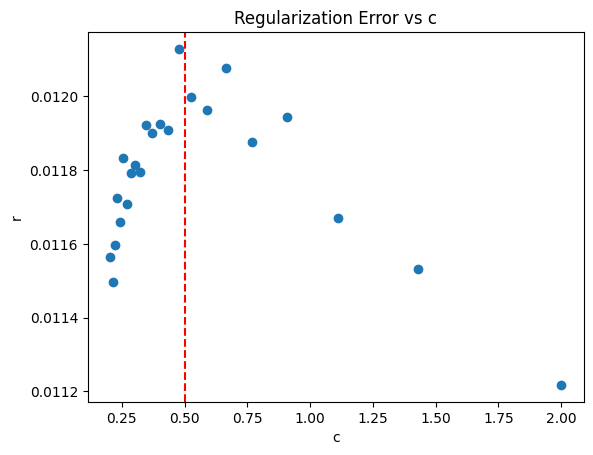

In [ ]:
plt.plot(c_list, reg_err, linestyle='-')
plt.scatter(c_list, test_mse)
plt.axvline(x=1/(mu**2+1), color='red', linestyle='--')
plt.xlabel('c')
plt.ylabel('r')
plt.title('Regularization Error vs c')
plt.show()

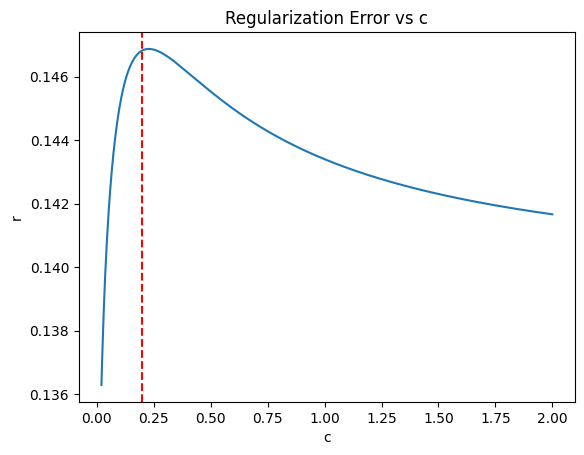

In [ ]:
c_list = []
reg_err = []
d = 500
N = 750
mu = 2
r = 70
U,S,Vh,X = create_X(d,n,r)
sigma = S

a = int(d/2)
b = int(d*50)
for i in range(a,b):
  c = d/i
  c_list.append(c)
  reg = regularization_error(c, mu, r, sigma)
  reg_err.append(reg)

plt.plot(c_list, reg_err, linestyle='-')
plt.axvline(x=1/(mu**2+1), color='red', linestyle='--')
plt.xlabel('c')
plt.ylabel('r')
plt.title('Regularization Error vs c')
plt.show()

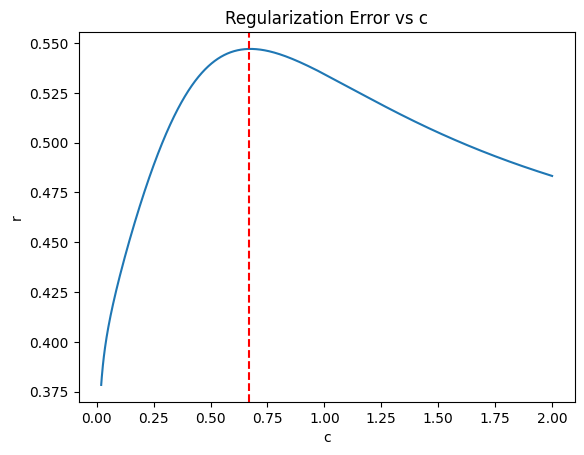

In [ ]:
c_list = []
reg_err = []
d = 500
N = 750
mu = 0.7
r = 200
U,S,Vh,X = create_X(d,n,r)
sigma = S

a = int(d/2)
b = int(d*50)
for i in range(a,b):
  c = d/i
  c_list.append(c)
  reg = regularization_error(c, mu, r, sigma)
  reg_err.append(reg)

plt.plot(c_list, reg_err, linestyle='-')
plt.axvline(x=1/(mu**2+1), color='red', linestyle='--')
plt.xlabel('c')
plt.ylabel('r')
plt.title('Regularization Error vs c')
plt.show()

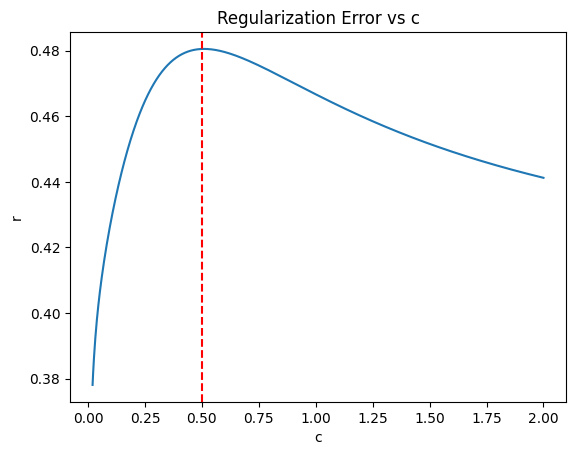

In [ ]:
c_list = []
reg_err = []
d = 500
N = 750
mu = 1
r = 200
U,S,Vh,X = create_X(d,n,r)
sigma = S

a = int(d/2)
b = int(d*50)
for i in range(a,b):
  c = d/i
  c_list.append(c)
  reg = regularization_error(c, mu, r, sigma)
  reg_err.append(reg)

plt.plot(c_list, reg_err, linestyle='-')
plt.axvline(x=1/(mu**2+1), color='red', linestyle='--')
plt.xlabel('c')
plt.ylabel('r')
plt.title('Regularization Error vs c')
plt.show()

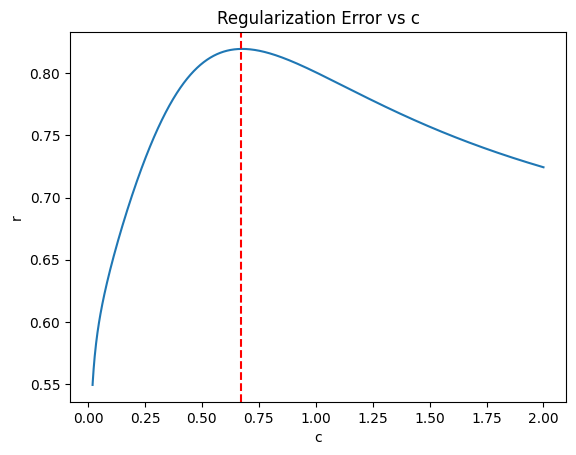

In [ ]:
c_list = []
reg_err = []
d = 500
N = 750
mu = 0.7
r = 300
U,S,Vh,X = create_X(d,n,r)
sigma = S

a = int(d/2)
b = int(d*50)
for i in range(a,b):
  c = d/i
  c_list.append(c)
  reg = regularization_error(c, mu, r, sigma)
  reg_err.append(reg)

plt.plot(c_list, reg_err, linestyle='-')
plt.axvline(x=1/(mu**2+1), color='red', linestyle='--')
plt.xlabel('c')
plt.ylabel('r')
plt.title('Regularization Error vs c')
plt.show()

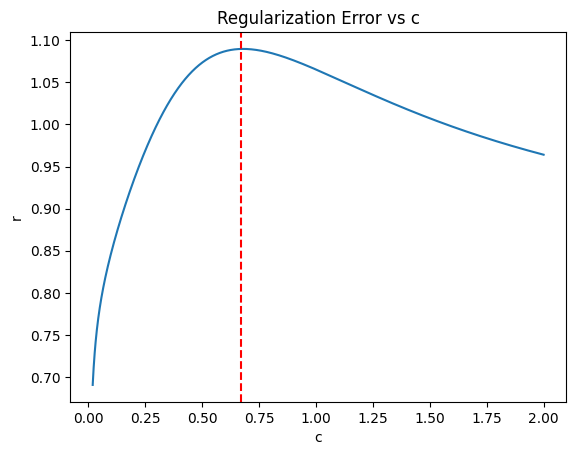

In [ ]:
c_list = []
reg_err = []
d = 500
N = 750
mu = 0.7
r = 400
U,S,Vh,X = create_X(d,n,r)
sigma = S

a = int(d/2)
b = int(d*50)
for i in range(a,b):
  c = d/i
  c_list.append(c)
  reg = regularization_error(c, mu, r, sigma)
  reg_err.append(reg)

plt.plot(c_list, reg_err, linestyle='-')
plt.axvline(x=1/(mu**2+1), color='red', linestyle='--')
plt.xlabel('c')
plt.ylabel('r')
plt.title('Regularization Error vs c')
plt.show()